# EECS 731 Final Project - Clothing One
## Clustering

In [1]:
import pandas as pd
import pickle

In [2]:
reviews = pickle.load(open("../Data/reviews.pkl", "rb" ))
rented_for_encoding = pickle.load(open("../Data/rented_for_encoding.pkl", "rb"))
body_type_encoding = pickle.load(open("../Data/body_type_encoding.pkl", "rb"))
category_encoding = pickle.load(open("../Data/category_encoding.pkl", "rb"))

In [3]:
reviews.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2


In [4]:
rented_for_encoding.head()

,encoding
labels,
date,0
everyday,1
formal affair,2
other,3
party,4


In [5]:
body_type_encoding.head()

,encoding
labels,
apple,0
athletic,1
full bust,2
hourglass,3
pear,4


In [6]:
category_encoding.head()

,encoding
labels,
ballgown,0
blazer,1
blouse,2
blouson,3
bomber,4


## Scenario:
* User is looking at a product or has a product in their cart. We take the user's body type and get a cluster similar to it.

* Cluster people by body features, then filter by occassion

* Could look at most common items for a specific occasion

* Come up with a score combining date (recent better), rating, and percentage of users who said item fit


### Other Notes
* Do an elbow chart

In [7]:
userDetails = reviews[['age', 'body_type','height','weight', 'user_id', 'bust_volume', 'bust_height']].copy()
#add weight to the body_type by creating another column and cubing it - CONSIDER REMOVING THIS

print('userDetails Length: ' + str(len(userDetails)))
userDetails.head()

userDetails Length: 146381


,age,body_type,height,weight,user_id,bust_volume,bust_height
0,28,3,68.0,137,420272,590,4
1,36,6,66.0,132,273551,390,2
2,34,4,65.0,135,909926,480,3
3,27,1,69.0,145,151944,390,2
4,45,1,68.0,138,734848,310,2


In [8]:
#One-hot encode body_type for KMEANS

b = body_type_encoding.copy()
b.reset_index(inplace=True)

dictBody_type = b.to_dict()
for i, row in b.iterrows():
    userDetails[row['labels']] = 0
    
for index, row in userDetails.iterrows():
    userDetails.at[index, dictBody_type['labels'][row['body_type']]] = 1
    
userDetails.drop(columns=['body_type'],inplace = True)
print(userDetails.head())


   age  height  weight  user_id  bust_volume  bust_height  apple  athletic  \
0   28    68.0     137   420272          590            4      0         0   
1   36    66.0     132   273551          390            2      0         0   
2   34    65.0     135   909926          480            3      0         0   
3   27    69.0     145   151944          390            2      0         1   
4   45    68.0     138   734848          310            2      0         1   

   full bust  hourglass  pear  petite  straight & narrow  
0          0          1     0       0                  0  
1          0          0     0       0                  1  
2          0          0     1       0                  0  
3          0          0     0       0                  0  
4          0          0     0       0                  0  


In [9]:
userDetailsNoDuplicates = userDetails.drop_duplicates(keep = 'first').copy()
print('userDetailsNoDuplicates Length: ' + str(len(userDetailsNoDuplicates)))
userIdsNoDups = userDetailsNoDuplicates['user_id'].copy()
userDetailsNoDuplicates.reset_index(inplace=True)
userDetailsNoDuplicates.drop(columns=['user_id', 'index'], inplace=True)

userDetailsNoDuplicates.head()

#One-hot encode body_type for KMEANS

userDetailsNoDuplicates Length: 77347


,age,height,weight,bust_volume,bust_height,apple,athletic,full bust,hourglass,pear,petite,straight & narrow
0,28,68.0,137,590,4,0,0,0,1,0,0,0
1,36,66.0,132,390,2,0,0,0,0,0,0,1
2,34,65.0,135,480,3,0,0,0,0,1,0,0
3,27,69.0,145,390,2,0,1,0,0,0,0,0
4,45,68.0,138,310,2,0,1,0,0,0,0,0


## Model 1 - KMEANS

In [10]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {}
mapping2 = {} 
K = range(1,50, 10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(userDetailsNoDuplicates) 
    kmeanModel.fit(userDetailsNoDuplicates)     
      
    distortions.append(sum(np.min(cdist(userDetailsNoDuplicates, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / userDetailsNoDuplicates.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(userDetailsNoDuplicates, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / userDetailsNoDuplicates.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('Elbow') 
plt.show() 

<Figure size 640x480 with 1 Axes>

In [11]:
#predict for our data set
numClusters = 10
print(userDetailsNoDuplicates.head())
kmeans =  KMeans(n_clusters=numClusters, random_state=0).fit(userDetailsNoDuplicates)
kmeansResults = kmeans.predict(userDetailsNoDuplicates)
print(kmeansResults)

   age  height  weight  bust_volume  bust_height  apple  athletic  full bust  \
0   28    68.0     137          590            4      0         0          0   
1   36    66.0     132          390            2      0         0          0   
2   34    65.0     135          480            3      0         0          0   
3   27    69.0     145          390            2      0         1          0   
4   45    68.0     138          310            2      0         1          0   

   hourglass  pear  petite  straight & narrow  
0          1     0       0                  0  
1          0     0       0                  1  
2          0     1       0                  0  
3          0     0       0                  0  
4          0     0       0                  0  
[2 1 5 ... 2 2 5]


In [12]:
#print(pd.DataFrame(kmeansResults))
#userDetailsNoDuplicates.reset_index(inplace=True)
#print(userDetailsNoDuplicates)
userDetailsNoDupsResults =userDetailsNoDuplicates.copy()
userDetailsNoDupsResults['kmeans_cluster'] = pd.DataFrame(kmeansResults)
userDetailsNoDupsResults.head()
# print(len(userDetailsNoDupsResults))
# userDetailsNoDupsResults.head()
#print(userDetailsNoDupsResults)

,age,height,weight,bust_volume,bust_height,apple,athletic,full bust,hourglass,pear,petite,straight & narrow,kmeans_cluster
0,28,68.0,137,590,4,0,0,0,1,0,0,0,2
1,36,66.0,132,390,2,0,0,0,0,0,0,1,1
2,34,65.0,135,480,3,0,0,0,0,1,0,0,5
3,27,69.0,145,390,2,0,1,0,0,0,0,0,1
4,45,68.0,138,310,2,0,1,0,0,0,0,0,4


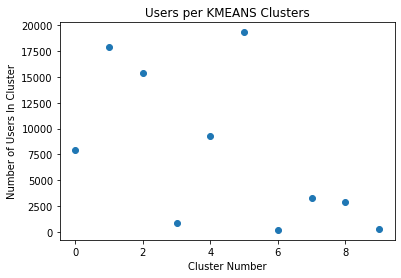

In [13]:
#visualize the clusters
dict = {}

for i, row in userDetailsNoDupsResults.iterrows():    
    dict[row['kmeans_cluster']] = dict.get(row['kmeans_cluster'], 0) + 1
    
z = pd.DataFrame(list(dict.items())).iloc[0:numClusters]
x = z[0]
y = z[1]

plt.scatter(x, y) 
plt.xlabel('Cluster Number') 
plt.ylabel('Number of Users In Cluster') 
plt.title('Users per KMEANS Clusters') 
plt.show() 

In [14]:
#merge clusters back
# print(len(userIdsNoDups))
# print(len(userDetailsNoDupsResults))
# print(len(kmeansResults))

# userDetailsNoDupsResults['user_id'] = userIdsNoDups
# dictCols = userDetailsNoDupsResults[['user_id', 'kmeans_cluster']]
# dictCols.set_index('user_id', inplace=True)
# #print(dictCols.info)
# print(dictCols.head())

# print(dictCols.index.is_unique)
# userIdDict = dictCols.to_dict(orient='index')

# permKey = 0

# for key,value in userIdDict.items():
#    print(key, value)
#    permKey = 0
userDetails['kmeans_cluster'] = kmeans.predict(userDetails.drop(columns=['user_id']))
reviews['kmeans_cluster'] = userDetails['kmeans_cluster'].copy()
reviews.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4,2
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2,1
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3,5
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2,1
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2,4


### Post Model Work

* Cluster people by body features, then filter by occassion
* Could look at most common items for a specific occasion
* Come up with a score combining date (recent better), rating, and percentage of users who said item fit

In [15]:
reviewsToFilter = reviews.copy()
reviewsToFilter.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4,2
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2,1
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3,5
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2,1
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2,4


In [16]:
#this corresponds to rented_for
userOccasion = 6
userBodyCluster = 1

reviewsByOccasion = reviewsToFilter[reviewsToFilter['rented_for'] == userOccasion]
reviewsByOccasion = reviewsByOccasion[reviewsByOccasion['kmeans_cluster'] == userBodyCluster]
reviewsByOccasion.reset_index(drop=True, inplace=True)
print('Number of occasion instances: ' + str(len(reviewsByOccasion)))
reviewsByOccasion.head()

Number of occasion instances: 747


,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,58,6,61,fit,68.0,2923916,10,6,2017-10-23,8,886843,118,390,3,1
1,28,0,61,large,63.0,2796868,8,6,2016-06-19,14,732678,135,390,3,1
2,27,3,16,fit,65.0,1725162,10,6,2017-05-22,8,27229,142,390,2,1
3,50,6,23,fit,64.0,2918587,10,6,2017-10-26,4,46566,116,390,3,1
4,27,3,16,large,68.0,364862,10,6,2017-07-07,4,157520,117,390,3,1


In [17]:
# generate most common item categories for occasion
catCounts = reviewsByOccasion['category'].value_counts().to_frame()
catCounts.columns=['count']
catCounts.head()

,count
16,362
44,65
45,59
32,51
26,43


In [18]:
#Come up with a score combining date (recent better), rating, and percentage of users who said item fit

# date score = 10 * 1 / fourth root(days since review_date) # Max score is 10, start with most recent date in set
# rating score = 1 * rating
# fit score = 10 * percentage of users who said item fit

mostRecentDate = reviewsByOccasion['review_date'].max()

#generate daysSinceReview
#reviewsByOccasion['daysSinceReview'] = (mostRecentDate - reviewsByOccasion['review_date']).dt.days

#fit score
reviewsPerItem = reviewsByOccasion['item_id'].value_counts().to_frame()
reviewsPerItem.columns=['count']
reviewsPerItem['fit_count'] = 0
reviewsPerItem.head()

for index, row in reviewsByOccasion.iterrows():
    #print(reviewsPerItem.at[row['item_id'], 'fit_count'])
    if (row['fit'] == 'fit'):
        reviewsPerItem.at[row['item_id'], 'fit_count'] = reviewsPerItem.at[row['item_id'], 'fit_count'] + 1

reviewsPerItem['ratio'] = reviewsPerItem['fit_count'] / reviewsPerItem['count']
reviewsPerItem.head()

,count,fit_count,ratio
143094,6,3,0.500000
196859,6,2,0.333333
2456857,5,4,0.800000
2771965,5,3,0.600000
2771463,5,4,0.800000


In [19]:
def cube_root(num):
    return num ** (1. / 3)

#print(reviewsPerItem.at[reviewsByOccasion['item_id'][0], 'ratio'])
#print(reviewsByOccasion['item_id'][0])

reviewsByOccasion['fit_score'] = 0
fitDict = reviewsPerItem.drop(columns=['count', 'fit_count']).to_dict()
#print(fitDict['ratio'][143094])
#reviewsByOccasion['ratio'].applymap(lambda x: )
for index, row in reviewsByOccasion.iterrows():
    reviewsByOccasion.loc[index, 'fit_score'] = fitDict['ratio'][int(row['item_id'])] * 10


#reviewsByOccasion['b'] = 10 * reviewsPerItem.at[reviewsByOccasion['item_id'], 'ratio']
reviewsByOccasion['priority_score'] = (20 / cube_root((mostRecentDate - reviewsByOccasion['review_date']).dt.days)) + reviewsByOccasion['rating'] + reviewsByOccasion['fit_score']
reviewsByOccasion.drop(columns=['fit_score'], inplace = True)
#reviewsByOccasion['priority_score'] = reviewsByOccasion.apply(lambda x: (20 / cube_root((mostRecentDate - x['review_date']).dt.days)) + x['rating'])#10 * reviewsPerItem.at[x['item_id'][0], 'ratio'])

reviewsByOccasion.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster,priority_score
0,58,6,61,fit,68.0,2923916,10,6,2017-10-23,8,886843,118,390,3,1,24.763792
1,28,0,61,large,63.0,2796868,8,6,2016-06-19,14,732678,135,390,3,1,10.419249
2,27,3,16,fit,65.0,1725162,10,6,2017-05-22,8,27229,142,390,2,1,23.273797
3,50,6,23,fit,64.0,2918587,10,6,2017-10-26,4,46566,116,390,3,1,24.829964
4,27,3,16,large,68.0,364862,10,6,2017-07-07,4,157520,117,390,3,1,13.529172


In [24]:
recItems = reviewsByOccasion[['category', 'item_id', 'priority_score']].copy()
recItems = recItems[recItems['priority_score'] < 1000]
recItems.sort_values(by='priority_score', inplace = True, ascending= False)
recItems.head()

,category,item_id,priority_score
169,53,2564595,33.874011
474,16,1009245,30.000000
5,16,814981,30.000000
716,16,1661123,30.000000
167,16,487992,29.614997


## Model 2 - Agglomerative Clustering

In [21]:
# from sklearn.cluster import AgglomerativeClustering
# #train Agglormerative Clustering model
# aggResults = AgglomerativeClustering(n_clusters = 20).fit_predict(userDetailsNoDuplicates)

In [22]:
# aggResults = AgglomerativeClustering().fit_predict(userDetailsNoDuplicates)
# userDetailsNoDuplicates['agglormerative_cluster'] = pd.DataFrame(aggResults)
# userDetailsNoDuplicates['user_id'] = userIdsNoDups
# userDetailsNoDuplicates.head()